1. Setup

In [ ]:
### This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier
### to perform sentiment analysis on an IMDB dataset. This notebook trains a sentiment analysis model to classify movie reviews as 
### positive or negative, based on the text of the review. This is an example of binary—or two-class—classification, an important 
### and widely applicable kind of machine learning problem. You'll use the Large Movie Review Dataset that contains the text of 50,000
### movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. 
### The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

In [1]:
import matplotlib.pyplot as plt
import os #(enables operating system dependent functionality)
import re #(this is the regular expression module)
import shutil #(for high-level file and directory handling)
import string #(for common string operations)
import tensorflow as tf #(tensorflow core v 2.7)

from tensorflow.keras import layers #(takes ina tensor and outputs a tensor)
from tensorflow.keras import losses #(used to compute the crossentropy loss between actual and predicted values)

In [14]:
print(tf.__version__)

2.7.0


2. Pre-process Data

  > a) Download data from url and assign it to the variable 'dataset'

In [15]:
### Let's download and extract the dataset, then explore the directory structure. Here we use the Keras method "tf.keras.utils.get_file" to download the dataset. The method's purpose is to:
### download a file from a URL if it not already in the cache. Standard arguments = tf.keras.utils.get_file(fname=None, origin=None, untar=False, md5_hash=None, file_hash=None, 
### cache_subdir='datasets', hash_algorithm='auto', extract=False, archive_format='auto', cache_dir=None). The output is the path to the downloaded file, or "./" and the file itself
### using the supplied fname or "aclImdb_v1" in this case. The "untar" argument is deprecated in favor of extract argument, but it is a boolean, whether the file should be decompressed or not.
### In this case it needs to be decompressed because the source file is a ".tar.gz" file. A "".tar.gz" file is achieved by archiving files into a TAR file and then compressing
### it with the GNU zip utility. A tar file, often called a tarball, is a collection of files wrapped up in one single file for easy storage. Technically these are TGZ files,
### but nearly everyone calls both .tar and .tar.gz files simply “tar files.” Both the file path and file is assigned to the variable "dataset" in the command below.
### Note in downloading the file, the file is renamed from 'aclImdb_v1.tar.gz' to 'aclImdb_v1'. There is no sub-directory. Note: 'aclImdb_v1' is a directory with files in it.
### So the file is a directory. So we now have './aclImdb_v1' as the directory with the files in it.

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz" #(if you enter this into a browser it immediately starts downloadng a file)
dataset =  tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')


84140032/84125825 [==============================] - 5s 0us/step


In [16]:
### The type for 'dataset' is a string. That's the first clue this isn't a normal data file but rather a path.

type(dataset)

str

In [17]:
### If we enter the variable 'dataset' we get back the file name and path './aclImdb_v1'. The below comes from the "get file" command which names the file, gives the source (the url in this case) and
### establishes the directory to put the file under. I believe it has truncated the file extension ".tar.gz", but that it is referring to the same anyway.

dataset

'./aclImdb_v1'

In [18]:
### Note: './' is the file path for our data. Thus if I use the os.listdir() on it, I get the following. But you cannot run the os.listdir() command on either 'dataset' or './aclImdb_v1'. Also, 
### you don't get 'aclImdb_v1' as a file or folder. 'aclImdb_v1.tar.gz' is the compressed file. The get file command above has returned the original downloaded file, plus the others shown. 

os.listdir('./')

['.config', 'drive', 'aclImdb_v1.tar.gz', 'aclImdb', 'sample_data']

In [19]:
### Note the contents of './aclImdb/' below, including test and train data. 

os.listdir('./aclImdb/')

['README', 'train', 'imdb.vocab', 'imdbEr.txt', 'test']

In [20]:
### The os.path.* command is a Python command. os.path.dirname(path) = return the directory name of path. If 'path' is a directory, then it returns the directory name holding that directory.
### Note, the path name for the variable dataset is '.'. That's because dataset is set equal to './aclImdb_v1' which is the directory/file 'aclImdb_v1' and the path ".". So it is giving
### you the highest level directory name.

os.path.dirname(dataset)

'.'

In [23]:
os.listdir('./aclImdb/train/')

['urls_unsup.txt',
 'pos',
 'labeledBow.feat',
 'urls_neg.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'unsupBow.feat']



> b) Setup and identify folder structure & files



In [24]:
### os.path.join(path, *paths) = join one or more components of path and *paths, or "."  and 'aclImdb', intelligently. This method concatenates various path components
### with exactly one directory separator (‘/’) following each non-empty part except the last path component. If the last path component to be joined is empty
### then a directory separator (‘/’) is put at the end. If a path component represents an absolute path, then all previous components joined are discarded and
### joining continues from the absolute path component. In this case, the second argument, 'aclImdb' is the directory name introduced above.
### And it is merged intelligently with the path './' or 'dataset', which means 'aclImdb' is joined with './'  to become './aclImdb'. This is then set equal to the variable dataset_dir.
### I thought the two were already joined based on above, maybe this is just to be sure?

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [25]:
### See what is in the variable 'dataset_dir'.

dataset_dir

'./aclImdb'

In [26]:
### The os.listdir() command = method in python used to get the list of all files and directories in the specified directory. If we don't specify any directory, then list of files
### and directories in the current working directory will be returned. Here we use 'dataset_dir' and this get all the files and directories in '.aclImdb/'. There are 5 including the
### train and test data sets. This is the same contents we saw above.

os.listdir(dataset_dir)


['README', 'train', 'imdb.vocab', 'imdbEr.txt', 'test']

In [27]:
### The join command below just serves to define the variable "train_dir" as the 'train' directory currently residing inside the 'dataset_dir' or './aclImdb/' already.
### The os.listdir(train_dir) command produces a list of directories inside the 'train' folder, as shown below. These are directories not files and are text names.

train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'pos',
 'labeledBow.feat',
 'urls_neg.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'unsupBow.feat']

In [28]:
### This shows us what train_dir is.

train_dir

'./aclImdb/train'

In [29]:
### Here is how you see the first 5 files inside a particular directory.

positive = os.path.join(train_dir, 'pos')
os.listdir(positive)[:5]


['11422_8.txt', '2449_7.txt', '7327_10.txt', '6090_7.txt', '9167_7.txt']

In [30]:
### The aclImdb/train/pos and aclImdb/train/neg directories contain many text files, each of which is a single movie review. Let's take a look at one of them.
### Here he is using a known text file name inside 'pos' and the join function just serves to define the 'sample_file' variable.

sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [31]:
## Repeat the above for a second review.

sample_file2 = os.path.join(train_dir, 'pos/11883_8.txt')
with open(sample_file2) as f:
    print(f.read())


I saw this movie about a week ago and still keep thinking about it. I was very moved by this movie. I found the characters very believable and likable almost to a fault. As in real life though sometimes people disappoint, as was the case with Leo, who even though I liked his character I could not have been more disappointed when he was willing to have unprotected sex even though fully aware of his HIV status. I was also disappointed with Leo for rejecting the medicine available to him, and the awful way he treated Marcel when he decided to ship him back home on the train. I think this movie showed in a very real way why HIV numbers are up in young gay men. This is in no way meant to bash gays (I am gay) and movie very well could have been made about a young straight person who makes bad choices and seems unaware of the consequences to himself and others. The only part of the movie I couldn't understand was why the (gay friendly) family was unwilling to include Marcel in Leo's illness t

In [32]:
## Repeat the above for a second review.

sample_file2 = os.path.join(train_dir, 'pos/2179_8.txt')
with open(sample_file2) as f:
    print(f.read())


Prix de Beauté was made on the cusp of the changeover from silence to sound, which came a little later in Europe than in Hollywood. Originally conceived as a silent, it was released with a dubbed soundtrack in France, with a French actress speaking Louise Brooks' lines, but was released as a silent in Italy and other parts of Europe. I was lucky enough to see the Cineteca di Bologna's flawless new restoration of an Italian silent print at the Tribeca Film Festival. I haven't seen the talkie version yet, but I think it's safe to assume the silent version is much more satisfying, since by all reports the dubbing is poorly done (Louise Brooks is clearly speaking English, so there's no way her lips could be matched.) Also, the film is made entirely in the silent style, with few titles and little need for dialogue. Prix de Beauté tells its story visually, with exciting, imaginative camera-work. The opening is instantly kinetic, with rapidly-cut scenes of urban life and swimmers splashing at

> c) Establish training, validation & test data splits



In [ ]:
### Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful text_dataset_from_directory utility, 
### which expects a directory structure as follows.

### main_directory/
### ...class_a/
### ......a_text_1.txt
### ......a_text_2.txt
### ...class_b/
### ......b_text_1.txt
### ......b_text_2.txt

In [33]:
### To prepare a dataset for binary classification, you will need two folders on disk, corresponding to class_a and class_b. These will be the positive and 
### negative movie reviews, which can be found in aclImdb/train/pos and aclImdb/train/neg. As the IMDB dataset contains additional folders, you will remove 
### them before using this utility. Note, 'shutil.rmtree()' is a python utility. shutil.rmtree() = shutil.rmtree(path, ignore_errors=False, onerror=None). It will delete
### an entire directory tree; path must point to a directory (but not a symbolic link to a directory). If ignore_errors is true, errors resulting from failed removals
### will be ignored; if false or omitted, such errors are handled by calling a handler specified by onerror or, if that is omitted, they raise an exception.
### 'unsup' in this case is in the train folder already.

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)


In [34]:
### Notice the above command removes the 'unsup' file from the './aclImdb/train' or train_dir. 

os.listdir(train_dir)

['urls_unsup.txt',
 'pos',
 'labeledBow.feat',
 'urls_neg.txt',
 'neg',
 'urls_pos.txt',
 'unsupBow.feat']

In [35]:
### Next, you will use the text_dataset_from_directory utility to create a labeled tf.data.Dataset for train and validation data. Training data first. tf.data is a powerful collection of tools 
### for working with data. When running a machine learning experiment, it is a best practice to divide your dataset into three splits: train, validation, and test.
### The IMDB dataset has already been divided into train and test by directory name, but it lacks a validation set. Let's create a training and validation set using an 80:20 split of the training
### data by using the validation_split argument below for the tf.keras.utils.text_dataset_from_directory utility. The syntax is as follows: tf.keras.utils.text_dataset_from_directory(directory,
### labels='inferred', label_mode='int', class_names=None, batch_size=32, max_length=None, shuffle=True, seed=None, validation_split=None, subset=None, follow_links=False). There is a total of 25,000
### text files in the train folder. Some positive and some negative. The below command takes all 25,000 from both classes, pos and neg, shuffles them, reserves 20% for validation and returns
### the raw_train_ds for further use. The variable name, directory chosen, and the 'subset' argument being set equal to 'training' is how we know this is training data versus test.

batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
### Note: the method 'tf.keras.utils.text_dataset_from_directory()' will return a <<<tf.data.Dataset>>> that yields batches of texts from the subdirectories class_a and class_b, together with labels 0 and 1
### (0 corresponding to class_a and 1 corresponding to class_b). Only .txt files are supported at this time. Note, by default, labels='inferred', label_mode='int' from the method's parameters. So, we're
### now dealing with a tf.data.Dataset orgnization of the data. If label_mode is None, it yields string tensors of shape (batch_size,), containing the contents of a batch of text files.
### Otherwise, it yields a tuple (texts, labels), where texts has shape (batch_size,) and labels follows the following format: if label_mode is int, the labels are an int32 tensor of shape (batch_size,).
### if label_mode is binary, the labels are a float32 tensor of 1s and 0s of shape (batch_size, 1). if label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
### representing a one-hot encoding of the class index. So in this case, the dataset is a tuple of text and labels (texts, labels).

In [36]:
### As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. 
### As you will see in a moment, you can train a model by passing a dataset directly to <<<model.fit>>>. If you're new to tf.data, you can also iterate over 
### the dataset and print out a few examples as follows. NOTICE THE LABELS HAVE BEEN ADDED FOR YOU. This was done in the step above. The .take() method
### takes the top "n" examples from the object. I believe the .take() method works on tensors. The .numpy() method converts a tensors object to a numpy ndarray. Also,
### in the below output, the words "Review" and "Label" are added. The 'b' has to do with data formatting and is added automatically. The .take(1) is for one batch.

for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])


Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [37]:
### Notice the reviews contain raw text (with punctuation and occasional HTML tags like <br/>). You will see how to handle these in the following section.
### The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the 'class_names' property on the dataset.

print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])


Label 0 corresponds to neg
Label 1 corresponds to pos


In [38]:
### Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation. Note: When using the validation_split and subset
### arguments, make sure to either specify a random seed, or to pass shuffle=False, so that the validation and training splits have no overlap.

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [39]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)


Found 25000 files belonging to 2 classes.




> d) Standardize, tokenize, and vectorize data for training



In [ ]:
### Next, you will standardize, tokenize, and vectorize the data using the helpful tf.keras.layers.TextVectorization layer. Standardization refers to preprocessing the text,
### typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words,
### by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.
### As you saw above, the reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase 
### and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.


In [ ]:
### Note: To prevent training-testing skew (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the TextVectorization 
### layer can be included directly inside your model, as shown later in this tutorial.


In [40]:
### This is a custom standardization function for use in this exercise. It includes making all text lowercase and pulling out some HTML code breaks ie ',br />'. 
### regex_replace() just substitutes one value for another in a given variable. re.escape normally returns a string with all 
### non-alphanumerics backslashed; this is useful if you want to match an arbitrary literal string that may have regular expression metacharacters in it. Example is: 
### legal_chars = string.ascii_lowercase + string.digits + "!#$%&'*+-.^_`|~:"  -->  print('[%s]+' % re.escape(legal_chars))  -->  [abcdefghijklmnopqrstuvwxyz0123456789!\#\$%\&'\*\+\-\.\^_`\|\~:]+.
### Note, the command "'[%s]' % re.escape(legal_chars)" appears to be standard format with the exception of 'legal_chars'. So you just put this string in as what youy want to replace and all punctuation
### is replaced by whatever you substitute. Next, string.punctuation = !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~. 

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')


In [41]:
test1 = "This is a tests... % s to see %s how the commands *&^%$#@! work with 34% ?"
test2 = tf.strings.regex_replace(test1, 'see', 'seedoo')
test3 = tf.strings.regex_replace(test2, '[%s]' % re.escape(string.punctuation), '')
print(test3)

tf.Tensor(b'This is a tests  s to seedoo s how the commands  work with 34 ', shape=(), dtype=string)


In [42]:
legal_chars = string.ascii_lowercase + string.digits + "!#$%&'*+-.^_`|~:"
l2 = ('[%s]+' % re.escape(legal_chars))
print(l2) 

[abcdefghijklmnopqrstuvwxyz0123456789!\#\$%\&'\*\+\-\.\^_`\|\~:]+


In [43]:
### Next, you will create a TextVectorization layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the output_mode to 
### int to create unique integer indices for each token. Note that you're using the default split function, and the custom standardization function you defined above.
### You'll also define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values.
### Note, there is nothing that the below function is being applied to here. This is just the definition of the function. Here is the default:
### tf.keras.layers.TextVectorization(max_tokens=None, standardize='lower_and_strip_punctuation', split='whitespace', ngrams=None, output_mode='int', output_sequence_length=None, pad_to_max_tokens=False,
### vocabulary=None, idf_weights=None, sparse=False, ragged=False, **kwargs)

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


In [44]:
### In Python 3, however, the map function returns a map object which is a generator object. To do so, map() loops over the items of an input iterable (or iterables)
### and returns an iterator that results from applying a transformation function to every item in the original input iterable. Below, .map() is a javascript function (I think).
### The .js map() method creates a new array populated with the results of calling a provided function on every element in the calling array.(maybe the same?)
### The lambda function below takes an input (x, y) and returns x. This is how we drop the labels from the text data and now have only text.
### Next, you will call the adapt method to fit the state of the preprocessing layer to the dataset. Some preprocessing layers have an internal state that can be computed based
### on a sample of the training data. The list of stateful preprocessing layers is: TextVectorization: holds a mapping between string tokens and integer indices; StringLookup and IntegerLookup:
### hold a mapping between input values and integer indices; Normalization: holds the mean and standard deviation of the features. Discretization: holds information about value bucket boundaries.
### Crucially, these layers are non-trainable. Their state is not set during training; it must be set before training, either by initializing them from a precomputed constant,
### or by "adapting" them on data. You set the state of a preprocessing layer by exposing it to training data, via the adapt() method as shown here. I believe an index matched to
### tokens is created here. Below here the .get_vocabulary function shows the mapping.

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)


In [ ]:
type(vectorize_layer)

keras.layers.preprocessing.text_vectorization.TextVectorization

In [45]:
### Let's create a function to see the result of using this layer to preprocess some data.

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label


In [46]:
### The first step here retrieves a batch (of 32 reviews and labels) from the dataset using the 'next' and 'iter' commands. Then we grab the first review and label.
### The first review comes back as a tensor. The label comes back 'neg'. The vectorized review comes back as (1,250) array.

text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))


Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [47]:
### As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))


1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [48]:
### Apply functions to all three datasets: train, validate and test. I think the .map function just maps the labels back to the tensors or arrays. And 'vectorize_text()' is the
### function above that applies the 'vectorize_layer' function and then maps the labels back to each vector. This data is now prepared for the model.

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)


In [49]:
### This type is a subset of the tf.data.Dataset object.

type(train_ds)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [50]:
### To view an item in this object, using an iterator is a good approach. Each iteration, as shown, is 32x250 numpy array after being converted to an numpy array.
### 32 is the batch size. 250 is the vector for the text review.

iterator = train_ds.__iter__()
next = iterator.get_next()
example = next[0]
print(example.numpy())

[[   1    7    4 ...    0    0    0]
 [1354    2   61 ...    0    0    0]
 [  53  147    9 ...    0    0    0]
 ...
 [   2  435    5 ...    0    0    0]
 [   2 3137   65 ...    0    0    0]
 [1518 5282 1659 ...    0    0    0]]


In [51]:
example.numpy().shape


(32, 250)



> e) Configure the dataset for performance



In [52]:
### These are two important methods you should use when loading data to make sure that I/O does not become blocking. 
### .cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large
### to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.
### .prefetch() overlaps data preprocessing and model execution while training. You can learn more about both methods, as well as how to cache data to disk in the data performance guide.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

3. Create the Model

In [ ]:
### The Embedding layer:
### The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings).
### The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would
### experiment with the number of neurons in a Dense layer (see above, = 16). If you pass an integer to an embedding layer, the result replaces each integer with 
## the vector from the embedding table: result = embedding_layer(tf.constant([1, 2, 3])), result.numpy(), array([[ 0.01318491, -0.02219239,  0.024673  , -0.03208025,  0.02297195],
### [-0.00726584,  0.03731754, -0.01209557, -0.03887399, -0.02407478], [ 0.04477594,  0.04504738, -0.02220147, -0.03642888, -0.04688282]], dtype=float32). So each number
### becomes a 5 element numpy array. For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape (samples, sequence_length), where each entry is
### a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes (32, 10) (batch of 32 sequences of length 10)
### or (64, 15) (batch of 64 sequences of length 15). The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis.
### Pass it a (2, 3) input batch and the output is (2, 3, N). For more go here: https://www.tensorflow.org/text/guide/word_embeddings.

In [ ]:
### Dropout layer:
### tf.keras.layers.Dropout(rate, noise_shape=None, seed=None, **kwargs)
### The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
### Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged. Note that the Dropout layer only applies when
### training is set to True such that no values are dropped during inference. When using model.fit, training will be appropriately set to True automatically,
### and in other contexts, you can set the kwarg explicitly to True when calling the layer.

In [ ]:
### GlobalAveragePooling1D():
### Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to 
### handle input of variable length, in the simplest way possible. If the input is (32 x 250 x 16) and you apply this layer to the sequence dimension, you end up with
### an output of (32 x 16), as the 250 sequence length dimension disappears. 

In [ ]:
### Dense layer:
### Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument,
### kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True). These are all attributes of Dense.

In [53]:
### Establish the number of embedding dimensions

embedding_dim = 16

In [112]:
### Create the model. This is a sequential model. It starts with one embedding layer (max_features+1,embedding_dim) in shape. Then it has a dropout layer. The global pooling layer
### is like a softmax layer I believe, reducing each data point to a zero or one. Then another dropout layer, followed by a final Dense layer.
### Scenarios:
### base case: loss=.31, accuracy=.87
### layers.Dense(16),: loss=.61, accuracy=.64.
### layers.Dropout(.3),: loss=.31, accuracy=.87
### epochs=6: loss=.34, accuracy=.86
### Add Dense(16) & add Dropout(.2): loss=.57, accuracy=.85
### Add Dense(16) & add Dropout(.2) & epochs=6: loss=.37, accuracy=.86
### Add Dense(16) & add Dropout(.2) & epochs=4: loss=.32, accuracy=.87
### Add Dense(16) & add Dropout(.2) & epochs=3: loss=.31, accuracy=.87

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),   # (32,250,16)
  layers.Dropout(0.2),                                 # (32,250,16)  
  layers.GlobalAveragePooling1D(),                     # (32, 16)
  layers.Dropout(0.2),                                 # (32, 16)
  layers.Dense(1)])                                    # (32,1)


In [113]:
### Create a summary of the model.

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 16)          160016    
                                                                 
 dropout_26 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_11  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_27 (Dropout)        (None, 16)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_______________________________________________

In [114]:
### A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability
### (a single-unit layer with a sigmoid activation), you'll use losses.BinaryCrossentropy loss function. Note: I need to revisit loss functions and optimization
### but not now.

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))


4. Train the Model

In [115]:
### You will train the model by passing the dataset object to the fit method.

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 6s 8ms/step - loss: 0.6644 - binary_accuracy: 0.6867 - val_loss: 0.6147 - val_binary_accuracy: 0.7762
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5487 - binary_accuracy: 0.7999 - val_loss: 0.4984 - val_binary_accuracy: 0.8202
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4453 - binary_accuracy: 0.8436 - val_loss: 0.4206 - val_binary_accuracy: 0.8456
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3789 - binary_accuracy: 0.8640 - val_loss: 0.3743 - val_binary_accuracy: 0.8600
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3355 - binary_accuracy: 0.8791 - val_loss: 0.3456 - val_binary_accuracy: 0.8672
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3055 - binary_accuracy: 0.8895 - val_loss: 0.3264 - val_binary_accuracy: 0.8718
Epoch 7/10
625/625 [==============================] - 5s 8ms/ste

5. Evaluate the Model

In [116]:
### Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 3ms/step - loss: 0.3098 - binary_accuracy: 0.8741
Loss:  0.30979806184768677
Accuracy:  0.8740800023078918


In [59]:
### Create a graph of loss and accuracy. model.fit() returns a History object that contains a dictionary with everything that happened during training:

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

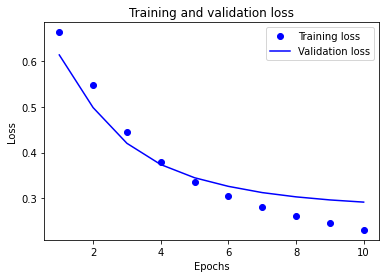

In [60]:
### There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison,
### as well as the training and validation accuracy:

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

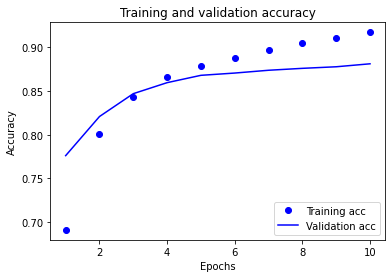

In [61]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
### In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy. Notice the training loss decreases with each epoch and the
### training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.
### This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training
### data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.
### For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use
### the tf.keras.callbacks.EarlyStopping callback.

6. Export the Model

In [62]:
### In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings 
### (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)


In [63]:
### Test it with `raw_test_ds`, which yields raw strings

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3099 - accuracy: 0.8739
0.8738800287246704


In [64]:
### Inference on new data. To get predictions for new examples, you can simply call model.predict().

examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.637708  ],
       [0.466421  ],
       [0.37946588]], dtype=float32)